## Spatial fidelity template
Infers a spatial fiedlity map for every individual from a ```.mymridon``` experiment file and saves it as a csv, which can be further analyzed in the optinal part or exported into other software such as RStudio.  
This notebook uses the following:
* the py-myrmidon library ([Documentation](https://formicidae-tracker.github.io/myrmidon/latest/))
* scipy spatial library ([Documentation](https://docs.scipy.org/doc/scipy/reference/spatial.html))

In [1]:
import py_fort_myrmidon as fm
import numpy as np  # Fundamental math library in python.
from datetime import datetime, timedelta  # For convenient handling of time and date
import pandas as pd  # To create a pandas dataframe, an equivalent to an R dataframe
from scipy.spatial import KDTree
from scipy.spatial.distance import cosine
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt  # Optional: for plorring
# Optional: makes plots interactive:
%matplotlib widget

In [2]:
f_myrmidon = "/home/user/Documents/experiment_folder/exp.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
t_start = datetime(2021, 2, 18, 0, 1).astimezone(tz=None)  # <year, month, day, hour, minute>
t_end = datetime(2021, 2, 20, 23, 59).astimezone(tz=None)

Load a period of tracking data, here 12 hours, and get the x and y limits of the tracking cooridnates. Infer mean ant body length and use it as internal radius for the hexagons ```r_int``` to tesselate the space.

In [3]:
identifiedFrames = fm.Query.IdentifyFrames(exp,
                                           start=fm.Time(t_start),
                                           end=fm.Time(t_start).Add(fm.Duration().Parse("1s")))
xlim = [0, identifiedFrames[0].Width]
ylim = [0, identifiedFrames[0].Height]
ant_radius = []
for ant in exp.Ants:
    ant_radius.append(fm.Query.ComputeMeasurementFor(experiment=exp, antID=ant, measurementTypeID=1)[0].LengthPixel)
r_int = np.mean(ant_radius)  # One ant radisu, arbitrary choice

A spatial tesselation of hexagons is used to define the sites where the observations of the individuals are counted. A nearest neighbour tree (KDTree) is used with the centers of the hexgons mentioned. For a given set of coordinates, a KDTree can be used to efficiently find the seed that is closest to the input coordinates, here the waypoints of the trajectory. The hexagonal boundaries are not defined explicitly. Simply by placing the hexagonal centers accordingly (see ```method ``` variable), the resulting pattern will be hexagonal or squared. The code in the following cell computes the hexagon centers that seed the KDTree.  
This part should probably only be edited w.r.t. the method and the internal radius.

In [4]:
method = 'vertical'
#method = 'horizontal'
#method = 'square'

if method == 'vertical':
    dx = 2*r_int
    dy = np.sqrt(3)*r_int
elif method == 'horizontal':
    dx = np.sqrt(3)*r_int
    dy = 2*r_int
elif method == 'square':
    dx = 2*r_int
    dy = 2*r_int
n_x = np.diff(xlim) // dx + 1
n_y = np.diff(ylim) // dy + 1
osx = n_x * dx - np.diff(xlim)
osy = n_y * dy - np.diff(ylim)
x = np.arange(start=xlim[0]-osx/2, step=dx, stop=n_x*dx+osx/2)
y = np.arange(start=ylim[0]-osy/2, step=dy, stop=n_y*dy+osy/2)
xm, ym = np.meshgrid(x, y)
if method == 'vertical':
    xm[::2] = xm[::2] + r_int
elif method == 'horizontal':
    ym[:, 1::2] = ym[:, 1::2] + r_int
sites = np.stack([xm.flatten(), ym.flatten()], axis=1)
kdtree = KDTree(sites)

The following is an iterator for fort mymrmidon time over days in a period. See Ant metadata template for explanation.

In [5]:
def fm_time_range(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield fm.Time(start_datetime + timedelta(n))

Count the observations of every individual in every site. In the end, the counts are normalized per individual counts where there is at least ```counts_cutoff``` times in total and set to zero for individuals that have been observed less often.

In [6]:
counts_cutoff = 0
# Create a dictionary with an array full of zeros and shape (number individuals x number sites) for each Space
counts = {}
for s in exp.Spaces:
    counts[s] = np.zeros((len(exp.Ants), len(sites)))
idxmap = dict(zip(exp.Ants, range(len(exp.Ants))))  # Maps the ant id to the matrix index

for t_begin in fm_time_range(t_start, t_end):
    trajectories = fm.Query.ComputeAntTrajectories(exp,
                                                   start=t_begin,
                                                   end=t_begin.Add(fm.Duration.Parse('24h')))
    for t in trajectories:
        dist, zone_indices = kdtree.query(t.Positions[:, 1:3])
        ind, cts = np.unique(zone_indices, return_counts=True)
        counts[t.Space][idxmap[t.Ant], ind] += cts
        
for s in exp.Spaces:
    row_sums = counts[s].sum(axis=1)[:, np.newaxis]
    counts[s] = np.divide(counts[s], row_sums, where=row_sums > counts_cutoff)  # Normalize per individual
    counts[s][np.where(row_sums <= counts_cutoff),:] = 0  # Reset individuals with insufficents total counts

Create a pandas dataframe and save it to a csv which can be imported in R for example. The index will be the ant id and the column is just a site numeration. Dataframe shape: number of ants x number of sites.

In [7]:
for s in exp.Spaces:
    df = pd.DataFrame(data=counts[s], index=exp.Ants)
    f_count = "normalized_counts_space_{}_{}_space_{}_{}.csv".format(exp.Name, exp.Spaces[s].Name, t_start, t_end)
    df.to_csv(f_count)

### Optional part 1: heatmap visualization
```ind_x``` and ```ind_y``` are used to arrange the subplots. Note the black plots for individuals that where not counted often enough.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
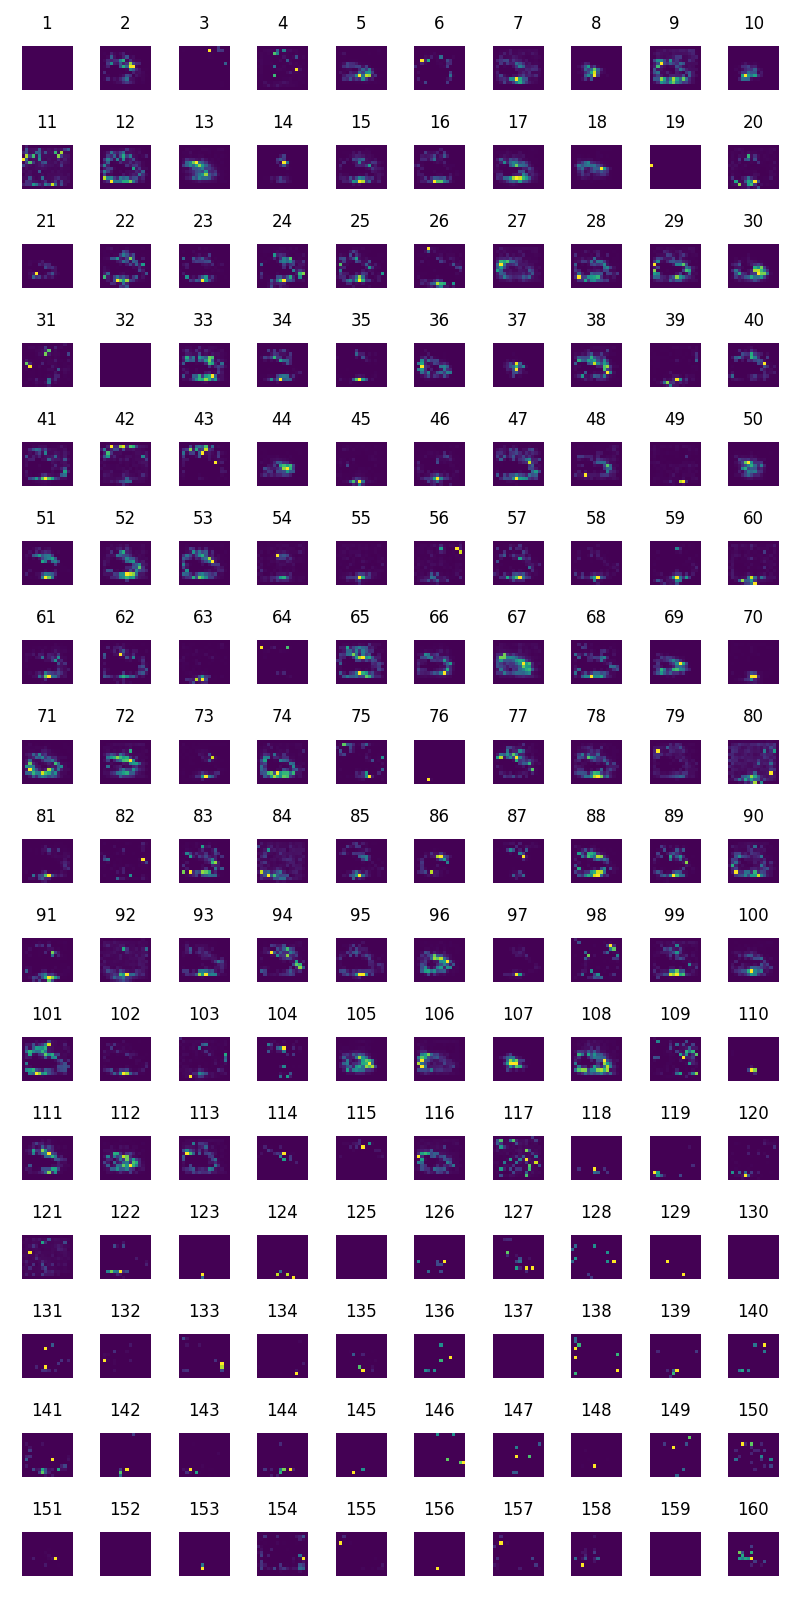

In [9]:
nb_plot_cols = 10
ind_y = nb_plot_cols
ind_x = len(exp.Ants) // nb_plot_cols

fig, ax = plt.subplots(ind_x,ind_y, figsize=(8,16))
for i in range(ind_x):
    for j in range(ind_y):
        ant_index = j + nb_plot_cols*i
        ax[i,j].imshow(counts[1][ant_index].reshape(xm.shape))
        ax[i,j].axis('equal')
        ax[i,j].axis('off')
        ax[i,j].set_title(ant_index+1)
fig.tight_layout()
plt.show()

## Optional part 2: ant - ant spatial fidelity similarity
Use cosine distance (other options are: correlation, euclidean, etc. see [here](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html) for ideas and documentation) to compare site count vectors among all individuals and save as a csv.

In [12]:
distance_correlation = np.zeros((len(exp.Ants),len(exp.Ants)))
for i in range(len(exp.Ants)):
    for j in range(i, len(exp.Ants)):
        distance_correlation[i, j] = cosine(counts[1][i], counts[1][j])
distance_correlation = distance_correlation + distance_correlation.T  # Make the matrix symmetric 
distance_correlation[np.isnan(distance_correlation)] = 1.0  # Assume that zero count individuals are maximally dissimilar
distance_correlation[np.isinf(distance_correlation)] = 1.0
df_similarity = pd.DataFrame(data=counts[1], index=exp.Ants)
f_similarity = "spatial_fidelity_similarity_{}_{}_{}.csv".format(exp.Name, t_start, t_end)
df_similarity.to_csv(f_similarity, index=exp.Ants, columns=exp.Ants)

Optionally: Create a similarity dendrogram and visualize it.

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
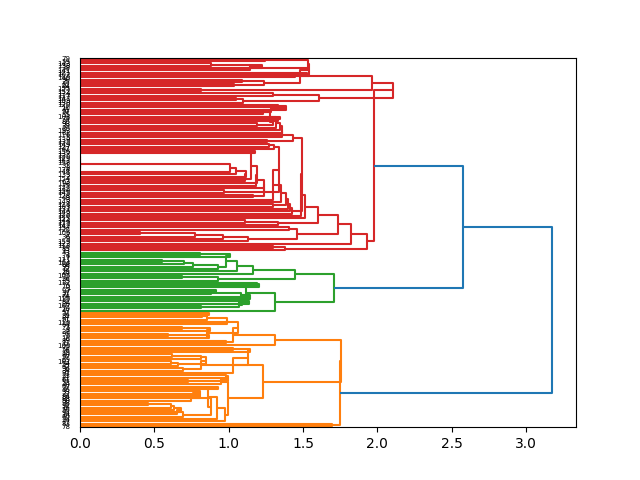

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
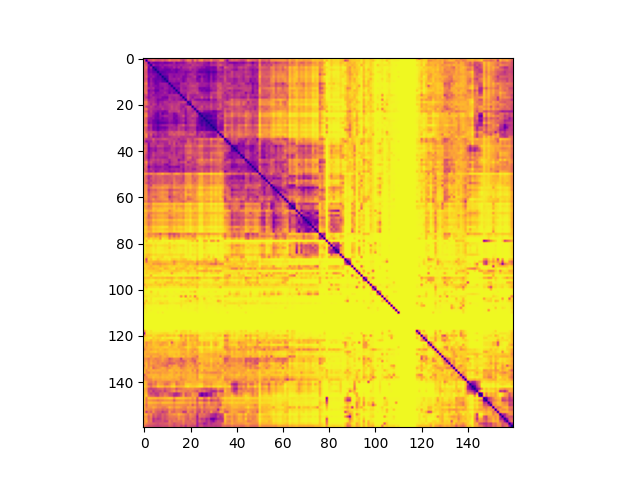

In [13]:
fig, ax = plt.subplots()
Y = sch.linkage(distance_correlation, method='centroid')
Z = sch.dendrogram(Y, orientation='right')
index = Z['leaves']
distance_correlation = distance_correlation[index, :]
distance_correlation = distance_correlation[:, index]
fig, ax = plt.subplots()
ax.imshow(distance_correlation, cmap=plt.get_cmap('plasma'))